# How Long Are the Boats?

In [30]:
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import colors,colorbar
import math
from math import radians, cos, sin, asin, sqrt
# from scipy import stats
import matplotlib.dates as mdates
from scipy import stats


In [23]:
import argparse
import googleapiclient
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from oauth2client.client import GoogleCredentials
credentials = GoogleCredentials.get_application_default()
# Construct the service object for interacting with the BigQuery API.
bigquery_service = build('bigquery', 'v2', credentials=credentials)

In [24]:
def Query(q):
    query_request = bigquery_service.jobs()
    query_data = {
        'query': (q)
    }
    query_response = query_request.query(
            projectId='world-fishing-827',
            body=query_data).execute()
    return query_response


In [25]:
q = '''
SELECT
integer(length/10)*10+5 length,
count(*) number
from
(select mmsi, avg(length) length from (SELECT 
  mmsi,
  INTEGER(JSON_EXTRACT(extra,"$.to_stern"))+INTEGER(JSON_EXTRACT(extra,"$.to_bow")) AS length,
//  MAX(INTEGER(JSON_EXTRACT(extra,""$.to_port""))+INTEGER(JSON_EXTRACT(extra,""$.to_starboard""))) AS width
FROM [data_production__projects.ORBCOMM_Historic_type5] 
WHERE mmsi IN (SELECT mmsi FROM [scratch_david_mmsi_lists.Combinedfishing_2014])
) WHERE length>0 AND length<500 AND length IS NOT NULL 
AND mmsi IN (select mmsi from
    [scratch_david_mmsi_lists.Combinedfishing_2014]) group by mmsi)
group by length
order by length asc'''

lengths = Query(q)

In [26]:
rows = []
for row in lengths['rows']:
    s = [item['v'] for item in row['f']]
    rows.append(s)
lengths =  rows

In [27]:
ls = [int(v[0]) for v in lengths]
numbers = [int(v[1]) for v in lengths]

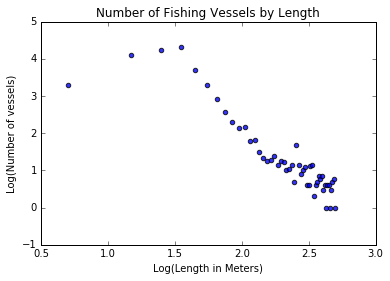

In [37]:
x = ls 
y = numbers
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.scatter(np.log10(x), np.log10(y), alpha=.8)#, color = color)
# logA = np.log10(x)
# logB = np.log10(y)
# coefficients = np.polyfit(logA, logB, 1)
# polynomial = np.poly1d(coefficients)
# ys = polynomial(np.log10(x))
# slope, intercept, r_value, p_value, std_err = stats.linregress(logA, logB)
# plt.scatter(np.log10(x), ys, color = 'red')


plt.title("Number of Fishing Vessels by Length")
plt.xlabel('Log(Length in Meters)')
plt.ylabel('Log(Number of vessels)')
plt.savefig("Length.png",bbox_inches='tight',dpi=150,transparent=True,pad_inches=.10)
plt.show()

## FAO database Numbers



The FAO estimates that there are about 
- 4.7 million fishing vessels in the world 
- 2.7 million fishing vessels with motors

Of the 2.7 million with motors:
- 2.16 million are smaller than 12 meters (80 percent are smaller than 12 meters)
- 540,000 are bigger than 12 meters (other 20 percent)
- 64,000 are bigger than 24 meters 

All numbers are from the FAO (http://www.fao.org/3/a-i3740t.pdf FAO Yearbook 2014), except the last one, which is from  (McCauley et al. 2016)

so, just for fun, let's say 5m = 2,160,000 + 2 million non-motorized fishing vessels
and 15m = 500,000.

According to McCauley et al, we are seeing 64% of the vessels bigger than 24m. If these vessels are distributed similarly to the rest of the distribution, they would be mostly concentrated in the smaller vessels. But because of AIS regulations, they are likely to be even *more* concentrated. Let's just add 40,000 (part of the <24 meters) + 36% of 64,000 to the 20 to 25 length = 40000+21000 = 60000

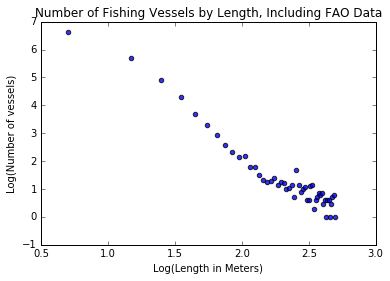

In [62]:
x = ls 
y_new = [4.16*10**6,5*10**5, numbers[2]+60000]+numbers[3:]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.scatter(np.log10(x), np.log10(y_new), alpha=.8)#, color = color)
# logA = np.log10(x)
# logB = np.log10(y)
# coefficients = np.polyfit(logA, logB, 1)
# polynomial = np.poly1d(coefficients)
# ys = polynomial(np.log10(x))
# slope, intercept, r_value, p_value, std_err = stats.linregress(logA, logB)
# plt.scatter(np.log10(x), ys, color = 'red')


plt.title("Number of Fishing Vessels by Length, Including FAO Data")
plt.xlabel('Log(Length in Meters)')
plt.ylabel('Log(Number of vessels)')
plt.savefig("Length_with_FAO.png",bbox_inches='tight',dpi=150,transparent=True,pad_inches=.10)
plt.show()

## What if fishing effort scales as the cube of the length?

In [67]:
fishing_scale = 3

effort = [l**fishing_scale for l in ls]

# I don't belive in fishing vessels bigger than 150m
effort_array = np.array(effort[:15])
number_array = np.array(y_new[:15])
number_array_ais = np.array(numbers[:15])
tot = 0
smaller_than_30 = 0
ais = 0
for e,n,a in zip(effort_array,number_array,number_array_ais):
    tot+=e*n
    if e**(1/float(fishing_scale))<30:
        smaller_than_30 += e*n
    ais += e*a
print int(100*(1-smaller_than_30/tot)), "percent of effort is by boats bigger than 30m"
print int(100*ais/tot), "percent of fishing effort is by vessels with AIS"

45 percent of effort is by boats bigger than 30m
50 percent of fishing effort is by vessels with AIS
